In [1]:
%%capture
%pip install ray pytorch_optimizer pytorch-lightning rich tensorboardx
#You may need to restart the kernel after installation

In [2]:
import torch
from ray import tune
import ray
import numpy as np
import os
from pytorch_optimizer import AvaGrad 
from train import train

## Example Experiment

In [3]:
# with log_to_driver=False the output of each trial will not be printed to the console
# if you went to change the logging RESTART THE KERNEL (otherwise ray will not be re-initialised)
ray.init(ignore_reinit_error=True, log_to_driver=False)

"""
The tune gridsearch will try all possible combinations of the parameters in the config dictionary.
By using the np.logspace function we can define a range of values to try for each parameter.
The argument "num" defines the number of values to try in the range.
    
"""

config = {
    "optimizer": tune.grid_search([torch.optim.SGD, AvaGrad]),
    "SAM": tune.grid_search([True, False]),
    "parameters":{
        "lr": tune.grid_search(np.logspace(-1, -6, num=1)),
        "weight_decay": tune.grid_search(np.logspace(-1, -6, num=1)),
    }
}

result_grid = train(config=config, epochs=5, cwd=os.path.join(os.getcwd()), logger_name="SmallNet", train_batches_per_epoch=0.01, val_batches_per_epoch=1)

2023-06-27 18:55:46,808	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,_report_on,date,done,epoch,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,step,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
LightningTrainer_7935f_00000,train_epoch_end,2023-06-27_18-56-10,True,4,"0_SAM=True,optimizer=ref_ph_e503d28a,lr=0.1000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,31415,True,35,14.5283,1.56207,14.5283,1687884970,2.30591,5,7935f_00000,2.30639
LightningTrainer_7935f_00001,train_epoch_end,2023-06-27_18-56-36,True,4,"1_SAM=False,optimizer=ref_ph_e503d28a,lr=0.1000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,31868,True,35,20.3921,1.09193,20.3921,1687884996,2.20057,5,7935f_00001,2.17442
LightningTrainer_7935f_00002,train_epoch_end,2023-06-27_18-57-05,True,4,"2_SAM=True,optimizer=ref_ph_6e59c6b3,lr=0.1000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,32294,True,35,23.6986,2.08355,23.6986,1687885025,2.30143,5,7935f_00002,2.30423
LightningTrainer_7935f_00003,train_epoch_end,2023-06-27_18-57-23,True,4,"3_SAM=False,optimizer=ref_ph_6e59c6b3,lr=0.1000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,32710,True,35,12.0336,1.67293,12.0336,1687885043,2.23213,5,7935f_00003,2.19951


2023-06-27 18:56:12,551	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'lightning_config/_module_init_config/config/optimizer': ('__ref_ph', 'e503d28a')}
2023-06-27 18:56:38,534	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'lightning_config/_module_init_config/config/optimizer': ('__ref_ph', 'e503d28a')}
2023-06-27 18:57:07,852	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'lightning_config/_module_init_config/config/optimizer': ('__ref_ph', '6e59c6b3')}
2023-06-27 18:57:25,436	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'lightning_config/_module_init_config/config/optimizer': ('__ref_ph', '6e59c6b3')}
2023-06-27 18:57:25,457	INFO tune.py:1111 -- Total run time: 93.72 seconds (93.68 seconds for the tuning loop).


## Analysis Examples

The Ray Tune documentation explains how to use a ResultGrid for data analysis

In [4]:
display(result_grid.get_dataframe())

,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,config/lightning_config/_trainer_init_config/callbacks,config/lightning_config/_trainer_init_config/limit_train_batches,config/lightning_config/_trainer_init_config/limit_val_batches,config/lightning_config/_trainer_init_config/logger,config/lightning_config/_trainer_init_config/max_epochs,config/lightning_config/_module_init_config/config/SAM,config/lightning_config/_module_init_config/config/optimizer,config/lightning_config/_module_init_config/config/parameters/lr,config/lightning_config/_module_init_config/config/parameters/weight_decay,logdir
0,train_epoch_end,2.306394,2.305910,4,35,1687884970,1.562067,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,1,None,5,True,<class 'torch.optim.sgd.SGD'>,0.1,0.1,/home/raffi/Projects/OPT4ML-project/tune_cifar...
1,train_epoch_end,2.174419,2.200567,4,35,1687884996,1.091932,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,1,None,5,False,<class 'torch.optim.sgd.SGD'>,0.1,0.1,/home/raffi/Projects/OPT4ML-project/tune_cifar...
2,train_epoch_end,2.304232,2.301429,4,35,1687885025,2.083555,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,1,None,5,True,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.1,0.1,/home/raffi/Projects/OPT4ML-project/tune_cifar...
3,train_epoch_end,2.199513,2.232128,4,35,1687885043,1.672931,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,1,None,5,False,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.1,0.1,/home/raffi/Projects/OPT4ML-project/tune_cifar...


,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,date,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,train_epoch_end,2.243123,2.293590,0,7,1687884991,15.951079,True,False,1,7935f_00001,2023-06-27_18-56-31,15.951079,31868,thinkpad-t14s,192.168.2.113,15.951079,1
1,train_epoch_end,2.251834,2.269631,1,14,1687884992,1.079754,True,False,2,7935f_00001,2023-06-27_18-56-32,17.030833,31868,thinkpad-t14s,192.168.2.113,17.030833,2
2,train_epoch_end,2.256016,2.256354,2,21,1687884993,1.157567,True,False,3,7935f_00001,2023-06-27_18-56-34,18.188399,31868,thinkpad-t14s,192.168.2.113,18.188399,3
3,train_epoch_end,2.199394,2.220276,3,28,1687884995,1.111741,True,False,4,7935f_00001,2023-06-27_18-56-35,19.300140,31868,thinkpad-t14s,192.168.2.113,19.300140,4
4,train_epoch_end,2.174419,2.200567,4,35,1687884996,1.091932,True,False,5,7935f_00001,2023-06-27_18-56-36,20.392072,31868,thinkpad-t14s,192.168.2.113,20.392072,5


<Axes: xlabel='epoch'>

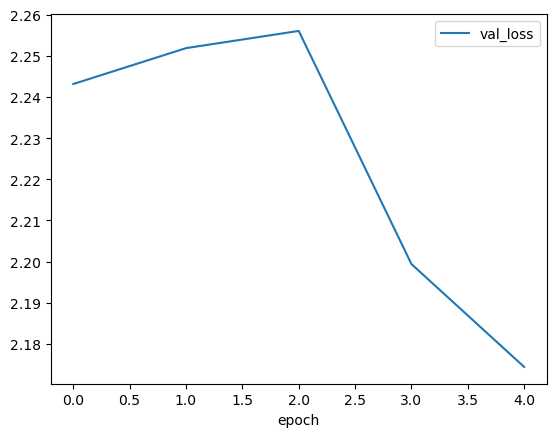

In [5]:
best_results = result_grid.get_best_result("val_loss", "min")
display(best_results.metrics_dataframe)
best_results.metrics_dataframe.plot("epoch", "val_loss")

Text(0, 0.5, 'Mean Validation Loss')

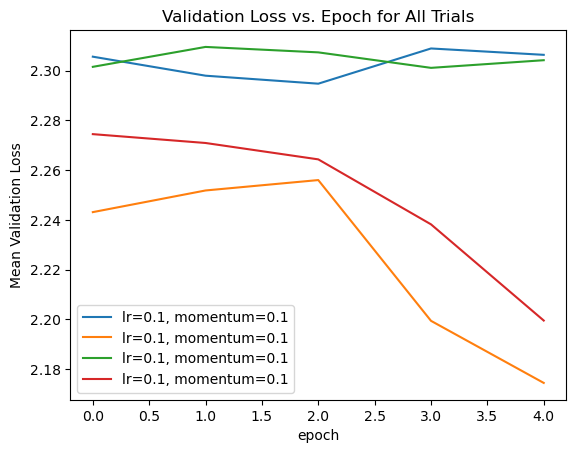

In [6]:
ax = None
for result in result_grid:
    parameters = result.config["lightning_config"]["_module_init_config"]["config"]["parameters"]
    label = f"lr={parameters['lr']}, momentum={parameters['weight_decay']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("epoch", "val_loss", label=label)
    else:
        result.metrics_dataframe.plot("epoch", "val_loss", ax=ax, label=label)
ax.set_title("Validation Loss vs. Epoch for All Trials")
ax.set_ylabel("Mean Validation Loss")

## Restoring Results from previous analysis

Results can be restored from the experiment_state.json file

In [8]:
analysis = tune.ExperimentAnalysis("tune_cifar10_SmallNet/experiment_state-2023-06-27_18-55-51.json")
display(result_grid.get_best_result("val_loss", "min").metrics_dataframe)

2023-06-27 19:00:08,136	INFO experiment_analysis.py:966 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.


,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,date,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,train_epoch_end,2.243123,2.293590,0,7,1687884991,15.951079,True,False,1,7935f_00001,2023-06-27_18-56-31,15.951079,31868,thinkpad-t14s,192.168.2.113,15.951079,1
1,train_epoch_end,2.251834,2.269631,1,14,1687884992,1.079754,True,False,2,7935f_00001,2023-06-27_18-56-32,17.030833,31868,thinkpad-t14s,192.168.2.113,17.030833,2
2,train_epoch_end,2.256016,2.256354,2,21,1687884993,1.157567,True,False,3,7935f_00001,2023-06-27_18-56-34,18.188399,31868,thinkpad-t14s,192.168.2.113,18.188399,3
3,train_epoch_end,2.199394,2.220276,3,28,1687884995,1.111741,True,False,4,7935f_00001,2023-06-27_18-56-35,19.300140,31868,thinkpad-t14s,192.168.2.113,19.300140,4
4,train_epoch_end,2.174419,2.200567,4,35,1687884996,1.091932,True,False,5,7935f_00001,2023-06-27_18-56-36,20.392072,31868,thinkpad-t14s,192.168.2.113,20.392072,5
